## Pfam seed random split

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import gc

In [2]:
data_partitions_dirpath = '../input/random_split/random_split'
print('Available dataset partitions: ', os.listdir(data_partitions_dirpath))

Available dataset partitions:  ['test', 'train', 'dev']


### Loading the data

In [3]:
def read_all_shards(partition='dev', data_dir=data_partitions_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)

test = read_all_shards('test')
dev = read_all_shards('dev')
train = read_all_shards('train')

partitions = {'test': test, 'dev': dev, 'train': train}
for name, df in partitions.items():
    print('Dataset partition "%s" has %d sequences' % (name, len(df)))

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


In [4]:
train.reset_index(inplace=True, drop=True)
dev.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

### Full Dataset Analysis

##### quick look at the most common families

In [5]:
train.groupby('family_id').size().sort_values(ascending=False).head(10)

family_id
Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
Lum_binding        1504
DNA_binding_1      1345
Chromate_transp    1265
Lipase_GDSL_2      1252
DnaJ_CXXCXGXG      1210
dtype: int64

In [6]:
def getTransitionMatForSequence(transitions, default):
    df = pd.DataFrame(transitions)
    df['shift'] = df[0].shift(-1)
    df['count'] = 1
    trans_mat = df.groupby([0, 'shift']).count().unstack().fillna(0)
    trans_mat.columns = trans_mat.columns.droplevel()
    return (default+trans_mat).fillna(0)

In [7]:
def makeHeatmap(df, familyId):
    mask = df.family_id == familyId
    famSeqs = df.loc[mask, 'sequence'].reset_index(drop=True)
    AAs = [aa for aa in 'GALMFWKQESPVICYHRNDTXUBOZ']
    seqs = famSeqs.apply(lambda seq: [aa for aa in seq])
    default = pd.DataFrame([[0]*len(AAs)]*len(AAs), columns=AAs, index=AAs, dtype='int64')
    transMat = default.copy()
    for seq in seqs: #tqdm(seqs):
        transMat += getTransitionMatForSequence(seq, default)
    maskX = transMat.sum(axis=1) != 0
    maskY = transMat.sum(axis=0) != 0
    transMat = transMat.loc[maskX, maskY]
    transMat = transMat.div(transMat.sum(axis=1), axis=0)
    return transMat

##### this is how the transition matrix heatmap looks like for the Methyltransf_25 family from the dev set

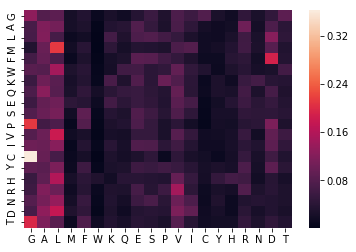

In [8]:
seaborn.heatmap(makeHeatmap(dev, 'Methyltransf_25'))

##### and for the Lipase_GDSL_2 family from the train set

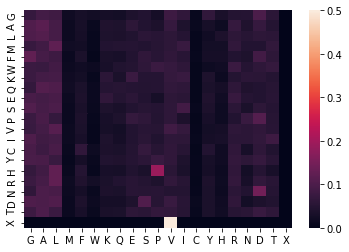

In [9]:
seaborn.heatmap(makeHeatmap(train, 'Lipase_GDSL_2'), vmax=0.5)

##### we should be able to observe a quite distinctive heatmap for each family, although families have been created using more sophisticated methods than can markov chains; they were created using profile HMMs, which models insertions and deletions and are based off the multiple sequence alignment. However, note that Pfam is not as simple as running HMMSearch on a seed sequence: "Pfam entries are manually annotated with functional information from the literature where available."
Pfam: The protein families database in 2021: J. Mistry, S. Chuguransky, L. Williams, M. Qureshi, G.A. Salazar, E.L.L. Sonnhammer, S.C.E. Tosatto, L. Paladin, S. Raj, L.J. Richardson, R.D. Finn, A. Bateman
Nucleic Acids Research (2020) doi: 10.1093/nar/gkaa913

##### based on the above, the best method to classify families is likely to be profile HMMs ... however, it is more interesting to create a deep learning model from scratch than running HMMER ... it is also possible for a deep learning model to surpass HMMER actually on Pfam! This was shown by Google research: 
Using Deep Learning to Annotate the Protein Universe
Maxwell L. Bileschi, David Belanger, Drew Bryant, Theo Sanderson, Brandon Carter, D. Sculley, Mark A. DePristo, Lucy J. Colwell
bioRxiv 626507; doi: https://doi.org/10.1101/626507

##### Let's check out the number of samples in each family

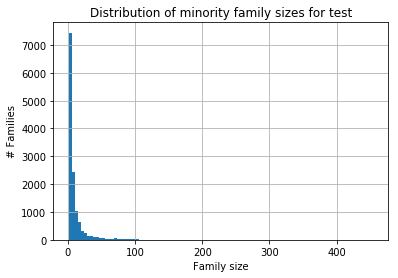

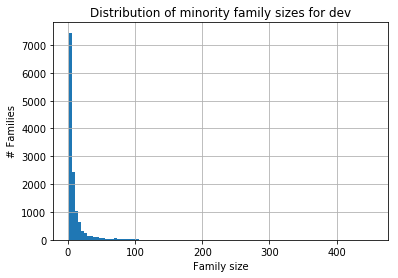

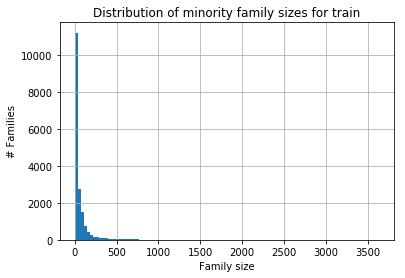

In [10]:
for name, partition in partitions.items():
    partition.groupby('family_id').size().hist(bins=100)
    plt.title('Distribution of minority family sizes for %s' % name)
    plt.ylabel('# Families')
    plt.xlabel('Family size')
    plt.show()

##### Zooming in a little

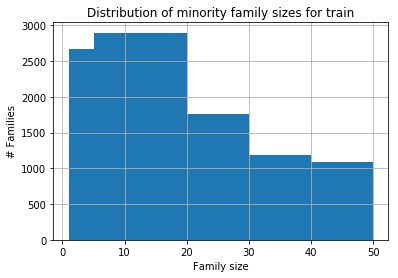

In [11]:
train.groupby('family_id').size().hist(bins=[1,5,10,20,30,40,50])
plt.title('Distribution of minority family sizes for train')
plt.ylabel('# Families')
plt.xlabel('Family size')
plt.show()

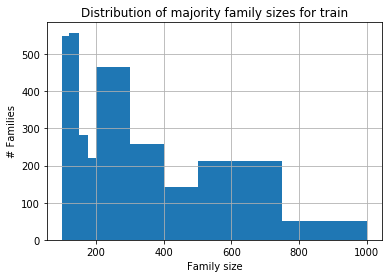

In [12]:
train.groupby('family_id').size().hist(bins=[100,120,150,175,200,300,400,500,750,1000])
plt.title('Distribution of majority family sizes for train')
plt.ylabel('# Families')
plt.xlabel('Family size')
plt.show()

##### Let's check the sequence length in the training/dev/test set

In [13]:
def makeSeqLenPlots(familyId=None):
    if familyId != None:
        famSeqsTrain = train.loc[train.family_id == familyId, 'sequence'].reset_index(drop=True)
        famSeqsDev = dev.loc[dev.family_id == familyId, 'sequence'].reset_index(drop=True)
        famSeqsTest = test.loc[test.family_id == familyId, 'sequence'].reset_index(drop=True)
    else:
        famSeqsTrain = train['sequence']
        famSeqsDev = dev['sequence']
        famSeqsTest = test['sequence']
    # Length of sequence in train data for specific family (optional).
    trainCharCount = famSeqsTrain.apply(len)
    devCharCount = famSeqsDev.apply(len)
    testCharCount = famSeqsTest.apply(len)

    def plot_seq_count(count, data_name):
        seaborn.distplot(count.values)
        plt.title(f'Sequence char count: {data_name}')
        plt.grid(True)

    plt.subplot(1, 3, 1)
    plot_seq_count(trainCharCount, 'Train')

    plt.subplot(1, 3, 2)
    plot_seq_count(devCharCount, 'Dev')

    plt.subplot(1, 3, 3)
    plot_seq_count(testCharCount, 'Test')

    plt.subplots_adjust(right=3.0)
    plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


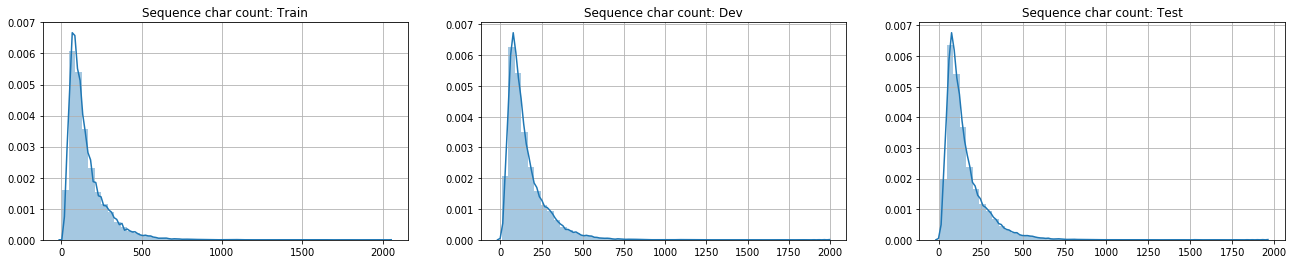

In [14]:
makeSeqLenPlots()

##### ... and we can also use this function to see the sequence lengths in a specific family

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


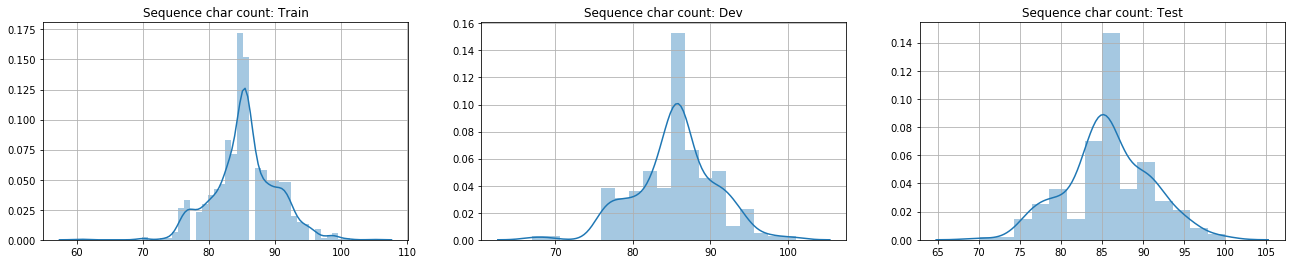

In [15]:
makeSeqLenPlots('Acetyltransf_7')

### Taking families of interest and optional traning size reduction via undersampling
- Further analysis to check correspondence between family Id, accession and family version number
- Reduced dataset analysis

##### Version number is unique for each family and family ID is unique for each family accession

In [16]:
print(len(train['family_accession'].apply(lambda x: x.split('.')[0]).unique()))
print(len(train['family_id'].unique()))
print(len(train['family_accession'].unique()))

17929
17929
17929


##### Number of Distinct classes in dev set

In [17]:
len(dev.family_accession.unique())

13071

##### Not super tricky, i.e. 
- we have all test/dev labels in train labels
- every test/dev family has at least 8 samples in training set

In [18]:
famSize = train.family_accession.value_counts()

# Minimum sample size in training set for a class in dev set - all test labels are in train labels
famSize.loc[dev.family_accession.unique()].min()

8

##### To be able to run on Kaggle, let's reduce the data by considering the 100 most common families only

In [19]:
#taking some families, by default, the 100 most common ones
familiesOfInterest = train.family_accession.value_counts()[:100] #100

In [20]:
mask = train.family_accession.isin(familiesOfInterest.index.values)
train = train.loc[mask,:]

mask = dev.family_accession.isin(familiesOfInterest.index.values)
dev = dev.loc[mask,:]

mask = test.family_accession.isin(familiesOfInterest.index.values)
test = test.loc[mask,:]

##### Let's check the distribution of the 20 most common families in train/dev/test

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


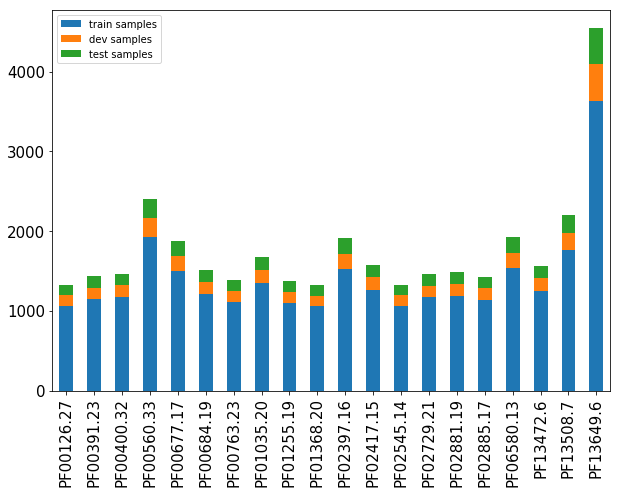

In [21]:
valCounts = pd.concat([pd.DataFrame(train.family_accession.value_counts()[:20]), 
           pd.DataFrame(dev.family_accession.value_counts()[:20]), 
           pd.DataFrame(test.family_accession.value_counts()[:20])], 
          axis=1)
valCounts.columns = ['train samples', 'dev samples', 'test samples']
valCounts.plot.bar(figsize = (10,7), fontsize = 15, stacked=True)

##### Let's see the histogram of sequence lengths in the reduced dataset

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


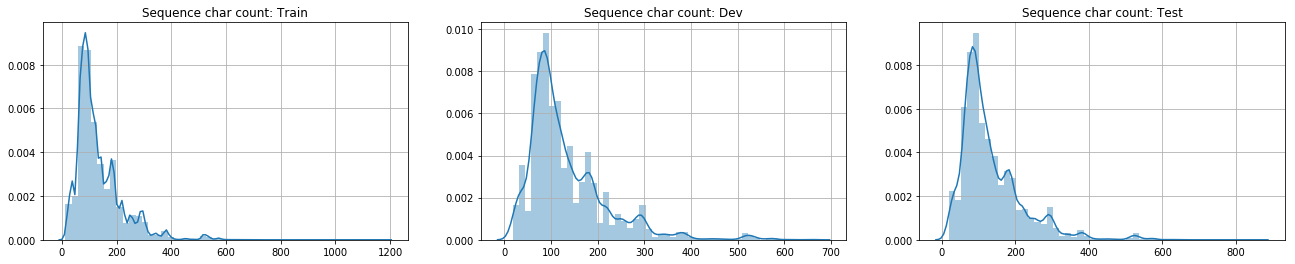

In [22]:
makeSeqLenPlots()

##### Final set sizes

In [23]:
print(len(train))
print(len(dev))
print(len(test))

92983
11565
11565


##### We could have also reduced the data by undersampling...

In [24]:
# undersampling
# train = train.groupby('family_accession').head(100)

### BERT Embedding

##### Let's try the BERT embedding from this famous paper:

@inproceedings{tape2019,
author = {Rao, Roshan and Bhattacharya, Nicholas and Thomas, Neil and Duan, Yan and Chen, Xi and Canny, John and Abbeel, Pieter and Song, Yun S},
title = {Evaluating Protein Transfer Learning with TAPE},
booktitle = {Advances in Neural Information Processing Systems}
year = {2019}
}

https://github.com/songlab-cal/tape

In [25]:
!pip install tape_proteins

    100% |████████████████████████████████| 71kB 1.1MB/s ta 0:00:01
    100% |████████████████████████████████| 307kB 3.7MB/s ta 0:00:01
You are using pip version 19.0.3, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [26]:
from tape import ProteinBertModel, TAPETokenizer

##### Check if GPU is available

In [27]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### Convert to half precision for faster speed

In [28]:
model = ProteinBertModel.from_pretrained('bert-base')
modelTAPE = model.to(device)
tokenizerTAPE = TAPETokenizer(vocab='iupac')  # iupac is the vocab for TAPE models, use unirep for the UniRep model

modelTAPE.half()  # convert to half precision
for layer in modelTAPE.modules():
    if isinstance(layer, torch.nn.BatchNorm2d):
        layer.float()

100%|██████████| 370264230/370264230 [00:10<00:00, 35953863.44B/s]


##### Let's tokenize the sequences

In [29]:
vocab_size = 25
max_length = 512 
trunc_type = "post"
padding_type = "post"

trainTAPE = [tokenizerTAPE.encode(w.upper()) for w in train['sequence']]
valTAPE = [tokenizerTAPE.encode(w.upper()) for w in dev['sequence']]
testTAPE = [tokenizerTAPE.encode(w.upper()) for w in test['sequence']]

##### Only consider up to the maximum length, set to 512 based off the sequence lengths histogram

In [30]:
trainTAPE = [np.array(t[:max_length]) for t in trainTAPE]
valTAPE = [np.array(t[:max_length]) for t in valTAPE]
testTAPE = [np.array(t[:max_length]) for t in testTAPE]

trainTAPE = [torch.from_numpy(t) for t in trainTAPE]
valTAPE = [torch.from_numpy(t) for t in valTAPE]
testTAPE = [torch.from_numpy(t) for t in testTAPE]

##### Let's pad the sequences

In [31]:
TAPEtrain = torch.nn.utils.rnn.pad_sequence(trainTAPE, batch_first=False)
TAPEvalidation = torch.nn.utils.rnn.pad_sequence(valTAPE, batch_first=False)
TAPEtest = torch.nn.utils.rnn.pad_sequence(testTAPE, batch_first=False)

##### Need to transpose to have (sample, length)

In [32]:
TAPEtrain = torch.transpose(TAPEtrain,0,1)
TAPEvalidation = torch.transpose(TAPEvalidation,0,1)
TAPEtest = torch.transpose(TAPEtest,0,1)

In [33]:
TAPEvalidation.size()

torch.Size([11565, 512])

##### Define batch sizes and dataloaders to we don't run out of GPU memory

In [34]:
from torch.utils.data import DataLoader
from tqdm import tqdm
batch_size = 8 #just reduce the batch size further if GPU is out of memory

dataloader_train = DataLoader(
    TAPEtrain,
    batch_size=batch_size
)

dataloader_validation = DataLoader(
    TAPEvalidation,
    batch_size=batch_size
)

dataloader_test = DataLoader(
    TAPEtest,
    batch_size=batch_size
)

In [35]:
del trainTAPE, valTAPE, TAPEtrain, TAPEvalidation
gc.collect()

0

In [36]:
torch.cuda.empty_cache() 

##### the version numbers are unique and we don't really care about them, so might as well just remove them

In [37]:
train_labels = train['family_accession'].apply(lambda x: x.split('.')[0])
validation_labels = dev['family_accession'].apply(lambda x: x.split('.')[0])
test_labels = test['family_accession'].apply(lambda x: x.split('.')[0])

##### If we have a new protein, we don't have the sequence alignment to the family, since we don't know the family, we are trying to find it! So it'd be cheating to use the aligned sequences, hence we just use the sequences 

In [38]:
train_seq = train['sequence']
dev_seq = dev['sequence']
test_seq = test['sequence']

del train, test, dev
gc.collect()

0

##### Let's get the pooled embeddings for each sequence (non-pooled would be more interesting but results in memory error in Kaggle)

In [39]:
TAPEncoded_train = []
with torch.no_grad():
    for batch in tqdm(dataloader_train):
        b = batch.to(torch.long)
        output = modelTAPE(b.to(device))[1] #1 for pooled, 0 for all amino acids in peptide encoded
        TAPEncoded_train.append(output.cpu().detach().numpy())
        torch.cuda.empty_cache() 
        del b, output
        gc.collect()

100%|██████████| 11623/11623 [42:39<00:00,  4.51it/s]


In [40]:
# import pickle
# path = "./" + "TAPEncoded_train_pooled" + ".pickle"
# output = open(path, 'w+b')
# pickle.dump(TAPEncoded_train, output)
# output.close()

##### For validation (dev)

In [41]:
TAPEncoded_val = []
for batch in tqdm(dataloader_validation):
    b = batch.to(torch.long)
    output = modelTAPE(b.to(device))[1]
    TAPEncoded_val.append(output.cpu().detach().numpy())
    torch.cuda.empty_cache() 
    del b, output
    gc.collect()

100%|██████████| 1446/1446 [05:14<00:00,  4.83it/s]


##### And for the test set

In [42]:
TAPEncoded_test = []
for batch in tqdm(dataloader_test):
    b = batch.to(torch.long)
    output = modelTAPE(b.to(device))[1]
    TAPEncoded_test.append(output.cpu().detach().numpy())
    torch.cuda.empty_cache() 
    del b, output
    gc.collect()

100%|██████████| 1446/1446 [05:15<00:00,  4.70it/s]


##### Let's merge the batches for train/dev/test

In [43]:
train_encoded = np.array(TAPEncoded_train[0])
for t in tqdm(TAPEncoded_train[1:]):
    train_encoded = np.concatenate([train_encoded,t], axis=0)

100%|██████████| 11622/11622 [07:32<00:00,  9.46it/s] 


In [44]:
dev_encoded = np.array(TAPEncoded_val[0])
for t in tqdm(TAPEncoded_val[1:]):
    dev_encoded = np.concatenate([dev_encoded,t], axis=0)

100%|██████████| 1445/1445 [00:01<00:00, 1323.41it/s]


In [45]:
test_encoded = np.array(TAPEncoded_test[0])
for t in tqdm(TAPEncoded_test[1:]):
    test_encoded = np.concatenate([test_encoded,t], axis=0)

100%|██████████| 1445/1445 [00:01<00:00, 1201.48it/s]


##### Final dev shape, embedding is in a 768-long vector space

In [46]:
dev_encoded.shape

(11565, 768)

### Pooled BERT Embedding + Dense Neural Net

##### Let's put a DNN on top to classify (just one layer, so really it's just logistic regression)

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer

label_tokenizer = Tokenizer(oov_token = -1)
label_tokenizer.fit_on_texts(train_labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(test_labels))

In [48]:
numclass = len(np.unique(training_label_seq))

##### Defining labels from zero

In [49]:
#labels should be 1 to num_classes, otherwise loss will be nan: https://github.com/keras-team/keras/issues/1244
training_label_seq = training_label_seq-1
validation_label_seq = validation_label_seq-1
test_label_seq = test_label_seq-1

In [50]:
del train_labels, validation_labels, test_labels
gc.collect()

0

##### Model architecture - going simple, the hard work should've been done by the BERT encoding

In [80]:
import tensorflow as tf
input_x = tf.keras.layers.Input(shape=(768,)) #768 is the embedding dimension
out = tf.keras.layers.Dense(numclass+1, activation="softmax")(input_x) #if you don't add 1, loss will be nan: https://github.com/keras-team/keras/issues/1244
model = tf.keras.Model(inputs=input_x, outputs=out)
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 101)               77669     
Total params: 77,669
Trainable params: 77,669
Non-trainable params: 0
_________________________________________________________________


##### We use a learning rate scheduler and early stopping
The 95% validation accuracy is quite nice

In [81]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=5)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(-epoch / 100))
history = model.fit(train_encoded, 
                    training_label_seq, 
                    epochs=100, 
                    validation_data=(dev_encoded, validation_label_seq), 
                    verbose=2, 
                    callbacks=[es, lr_schedule])

Train on 92983 samples, validate on 11565 samples
Epoch 1/100
 - 8s - loss: 3.5272 - acc: 0.2526 - val_loss: 2.8776 - val_acc: 0.4190
Epoch 2/100
 - 8s - loss: 2.5362 - acc: 0.5074 - val_loss: 2.2425 - val_acc: 0.6063
Epoch 3/100
 - 8s - loss: 2.0586 - acc: 0.6447 - val_loss: 1.8762 - val_acc: 0.6932
Epoch 4/100
 - 8s - loss: 1.7604 - acc: 0.7181 - val_loss: 1.6329 - val_acc: 0.7327
Epoch 5/100
 - 8s - loss: 1.5523 - acc: 0.7582 - val_loss: 1.4523 - val_acc: 0.7797
Epoch 6/100
 - 8s - loss: 1.3964 - acc: 0.7868 - val_loss: 1.3166 - val_acc: 0.8036
Epoch 7/100
 - 8s - loss: 1.2737 - acc: 0.8065 - val_loss: 1.2066 - val_acc: 0.8191
Epoch 8/100
 - 8s - loss: 1.1737 - acc: 0.8219 - val_loss: 1.1164 - val_acc: 0.8302
Epoch 9/100
 - 8s - loss: 1.0914 - acc: 0.8344 - val_loss: 1.0409 - val_acc: 0.8444
Epoch 10/100
 - 8s - loss: 1.0216 - acc: 0.8454 - val_loss: 0.9770 - val_acc: 0.8513
Epoch 11/100
 - 8s - loss: 0.9616 - acc: 0.8552 - val_loss: 0.9233 - val_acc: 0.8636
Epoch 12/100
 - 8s - los

##### Making predictions for test set

In [82]:
preds = model.predict(test_encoded)

##### Taking the class with the highest probability

In [83]:
preds = np.argmax(preds,axis=1) 

#### Final metric: testing accuracy


In [84]:
sum(preds==test_label_seq.T[0])/len(test_label_seq)*100

94.35365326415909

### One Hot Encoding + Residual Nets

##### Let's try our own method from scratch that doesn't rely on BERT and is quicker and see if we can get similar testing accuracy

In [55]:
train_sentences = train_seq.apply(lambda seq: [aa for aa in seq])
validation_sentences = dev_seq.apply(lambda seq: [aa for aa in seq])
test_sentences = test_seq.apply(lambda seq: [aa for aa in seq])

In [56]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

##### Use tensorflow's tokenizer and sequence padder

In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K

vocab_size = 25
embedding_dim = vocab_size
max_length = 512
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_portion = .8

tokenizer = Tokenizer(oov_token=oov_tok, num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type)

In [58]:
del train_sentences, train_sequences, validation_sentences, validation_sequences, test_sentences, test_sequences
gc.collect()

0

##### Train/dev/test shapes

In [59]:
print(train_padded.shape)
print(validation_padded.shape)
print(test_padded.shape)

(92983, 512)
(11565, 512)
(11565, 512)


##### Let's make the architecture similar to ProtCNN's (see paper above) because it outperformed HMMER

Creating the residual blocks with dilution

In [60]:
def residual_block(x, dil, filters):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(bn1)
    conv1 = tf.keras.layers.Conv1D(filters, 3, dilation_rate = dil, padding="same")(a1) #1100 filters and 31 kernel size in ProtCNN
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, 1, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    
    return x

In [61]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=5)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(-epoch / 100))

In [62]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

##### Relatively complex architecture containing 1D as well as 2D convolutions and skip connection (Residual Net)

- One-hot encoding for the amino acids
- First 1D Convolution along amino acids to capture if the same amino acid is nearby
- 1D convolution along ebedding dimension to check which amino acids are recurring close to each other
- Residual blocks to include possible skips
- 2D convolution to finish it off to combine resulting embedding dimension along the sequence
- Pooling and flattening and finally a Dense layer for multiclass classification
- Note: 2D Conv layer was added for fun, is not in ProtCNN

In [85]:
# instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope():
input_x = tf.keras.layers.Input(shape=(512,))
#will run out of memory if to_categorical is used, so need to one-hot encode here
x = tf.keras.layers.Embedding(vocab_size, vocab_size, embeddings_initializer=tf.keras.initializers.Identity(gain=1.0), trainable=False)(input_x)
x = tf.keras.layers.Permute(dims=[2, 1])(x)
x = tf.keras.layers.Conv1D(64, 8, padding="same")(x)
x = residual_block(x, 1, 64)
x = residual_block(x, 2, 64)
x = tf.keras.layers.Permute(dims=[2, 1])(x)
x = tf.keras.layers.Conv1D(64, 3, padding="same")(x)
x = residual_block(x, 1, 64)
x = residual_block(x, 2, 64) #4 blocks of these in ProtCNN
x = tf.keras.layers.Lambda(lambda x: K.expand_dims(x, -1))(x) #will not compile if not defined as lambda
x = tf.keras.layers.Conv2D(32, (4,4), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(8, (8,8), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPooling2D((64,64))(x)
#x = tf.keras.layers.Conv1D(8, 8, padding="same")(x)
#x = tf.keras.layers.MaxPooling1D(64)(x)
x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(numclass+1, activation="softmax")(x) #if you don't add 1, loss will be nan: https://github.com/keras-team/keras/issues/1244

model = tf.keras.Model(inputs=input_x, outputs=out)
optimizer = tf.keras.optimizers.Adam(lr=1e-5) #0.001 default learning rate was too large and learning was stuck

model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 512, 25)      625         input_5[0][0]                    
__________________________________________________________________________________________________
permute_4 (Permute)             (None, 25, 512)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 25, 64)       262208      permute_4[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [64]:
# with tpu_strategy.scope():
#     input_x = tf.keras.layers.Input(shape=(512,))
#     x = tf.keras.layers.Embedding(vocab_size, vocab_size, embeddings_initializer=tf.keras.initializers.Identity(gain=1.0), trainable=False)(input_x)
#     x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
    
#     x = tf.keras.layers.LSTM(64)(x)
#     out = tf.keras.layers.Dense(numclass, activation="softmax")(x)
#     model2 = tf.keras.Model(inputs=input_x, outputs=out)
#     model2.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
# model2.summary()

In [65]:
# history2 = model2.fit(train_padded, 
#                       training_label_seq, 
#                       epochs=100, 
#                       validation_data=(validation_padded, validation_label_seq), 
#                       callbacks = [lr_schedule],
#                       verbose=2)

##### Again, we got around 95% accuracy on dev set!
- Likely could be made better by avoiding the slight overfitting via regularization/dropout/model complexity reduction

In [86]:
history = model.fit(train_padded, 
                    training_label_seq, 
                    epochs=100, 
                    validation_data=(validation_padded, validation_label_seq), 
                    callbacks = [es,lr_schedule], 
                    verbose=2)

Train on 92983 samples, validate on 11565 samples
Epoch 1/100
 - 63s - loss: 2.3759 - acc: 0.4424 - val_loss: 0.8155 - val_acc: 0.8019
Epoch 2/100
 - 61s - loss: 0.5021 - acc: 0.8773 - val_loss: 0.4221 - val_acc: 0.8982
Epoch 3/100
 - 61s - loss: 0.2600 - acc: 0.9355 - val_loss: 0.3783 - val_acc: 0.9079
Epoch 4/100
 - 60s - loss: 0.1713 - acc: 0.9566 - val_loss: 0.2924 - val_acc: 0.9285
Epoch 5/100
 - 61s - loss: 0.1173 - acc: 0.9694 - val_loss: 0.3084 - val_acc: 0.9285
Epoch 6/100
 - 61s - loss: 0.0868 - acc: 0.9764 - val_loss: 0.3464 - val_acc: 0.9246
Epoch 7/100
 - 60s - loss: 0.0644 - acc: 0.9823 - val_loss: 0.2965 - val_acc: 0.9345
Epoch 8/100
 - 61s - loss: 0.0538 - acc: 0.9853 - val_loss: 0.2635 - val_acc: 0.9467
Epoch 9/100
 - 60s - loss: 0.0438 - acc: 0.9881 - val_loss: 0.2939 - val_acc: 0.9433
Epoch 10/100
 - 60s - loss: 0.0368 - acc: 0.9898 - val_loss: 0.2894 - val_acc: 0.9435
Epoch 11/100
 - 61s - loss: 0.0318 - acc: 0.9911 - val_loss: 0.3158 - val_acc: 0.9396
Epoch 12/100


In [87]:
preds = model.predict(test_padded)

In [88]:
preds = np.argmax(preds,axis=1) 

##### Final metric: testing accuracy

In [89]:
sum(preds==test_label_seq.T[0])/len(test_label_seq)*100

94.67358408992649

##### In conclusion we got around 95% accuracy on 100 similarly-sized classes from scratch which is pretty amazing! We used two different methods, and could've done a lot of others, for example:
- HMMER
- LSTM
- k-NN in embedding dimension
- k-NN with Levenshtein distance
- BERT embedding for each amino acid (not pooled) and then ProtCNN (ResNet) layer on top instead of just DNN
- Ensemble of models
-...